In [11]:
import matplotlib.animation as animation

from brian2 import *


### global parameters
defaultclock.dt = 50*ms


### simulation code
def run_sim(N, K, F, Delta, p1, p2, omega_0, tau, sigma, random_seed=214040893):
    seed(random_seed)

    eqs = '''
    dTheta/dt = omega + K/N*coupling + F*sin(sigma*t - Theta + p): 1
    omega : Hz (constant) # intrinsic frequency
    coupling : 1
    p : 1
    '''

    oscillators = NeuronGroup(N, eqs, method='euler')
    oscillators.Theta = 'rand()*2*pi/240'  # random initial phase
    oscillators.p = p1


    #CHANGE THIS TO ANOTHER VALUE
    lorentzian_omegas = omega_0 + Delta * np.tan(np.pi * (np.random.rand(N) - 0.5))
    oscillators.omega = lorentzian_omegas


    connections = Synapses(oscillators, oscillators,
                        'coupling_post = sin(Theta_pre - Theta_post) : 1 (summed)')
    connections.connect()  # all-to-all

    mon = StateMonitor(oscillators, 'Theta', record=True)

   # Variable to hold the current value of z
    z_values = []

    @network_operation()
    def update_p() :
        if defaultclock.t <= tau :
            oscillators.p = p1
        else :
            oscillators.p = p2
    
    @network_operation()
    def compute_z():
        # Calculate z(t) using the current phases
        z = np.mean(np.exp(1j * (oscillators.Theta[:] - (sigma * defaultclock.t) - p2)))
        if defaultclock.t > tau:
            z_values.append(z)

    net = Network(oscillators, connections, mon, compute_z, update_p)
    net.run(20*second)

    return z_values
        

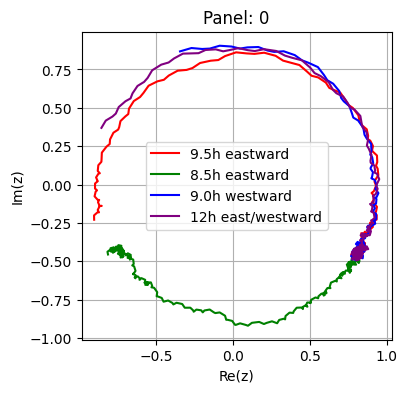

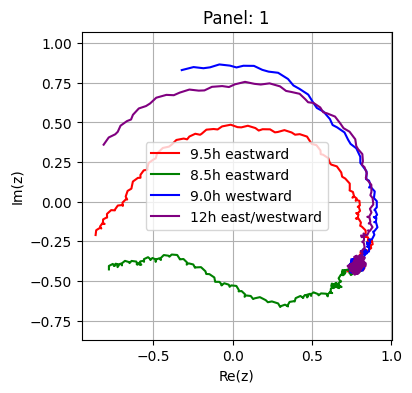

In [12]:
initial_values = [[10.0, 3.5, 1.4], [4.5, 3.5, 1.4]]
sigma = 2*pi/(24)*Hz
Delta = sigma
for count, arr in enumerate(initial_values): 
    K = arr[0] * Delta      # Coupling strength
    F = arr[1] * Delta # Amplitude of external driving force
    Omega = arr[2] * Delta
    omega_0 = sigma - Omega
    initial_p2 = [9.5, 8.5, -9, -12]
    colors = ['red', 'green', 'blue', 'purple']  # Colors for each travel point
    labels = ['9.5h eastward', '8.5h eastward', '9.0h westward', '12h east/westward']

    tau = 2*second  # Time of travel
    plt.figure(figsize=(4, 4))
    for i, p2 in enumerate(initial_p2):
        real_p2 = p2 * (2 * pi) / 24
        z_final = run_sim(100, K, F, Delta, 0, real_p2, omega_0, tau, sigma)
        z_real = np.real(z_final)
        z_imag = np.imag(z_final)
        plt.plot(z_real, z_imag, label=labels[i], color=colors[i])
    # Labels and formatting
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    plt.title(f"Panel: {count}")
    plt.legend()
    plt.axis("equal")
    plt.grid()
plt.show()



### Runtime Analysis for N (Number of Oscillators)

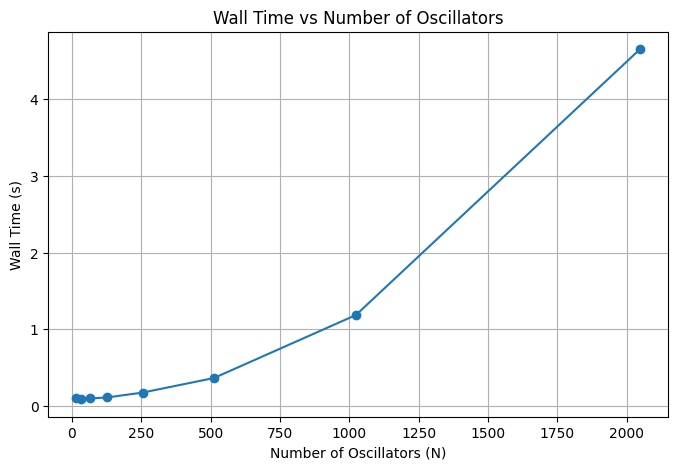

In [13]:
N_values = [16 * (2**i) for i in range(int(np.log2(2048 // 16)) + 1)] #Analyze N for powers of 2 from 16 to 2048
wall_times = []
sigma = 2*pi/(24)*Hz
Delta = sigma
K = 10.0 * Delta 
F = 3.5 * Delta 
Omega = 1.4 * Delta
omega_0 = sigma - Omega
tau = 2*second
p1 = 0
p2 = 9.5
for N in N_values:
    start_time = time.time()  
    run_sim(N, K, F, Delta, p1, p2, omega_0, tau, sigma) 
    end_time = time.time()
    wall_times.append(end_time - start_time) #Store time taken

plt.figure(figsize=(8, 5))
plt.plot(N_values, wall_times, marker='o')
plt.xlabel('Number of Oscillators (N)')
plt.ylabel('Wall Time (s)')
plt.title('Wall Time vs Number of Oscillators')
plt.grid()
plt.show()

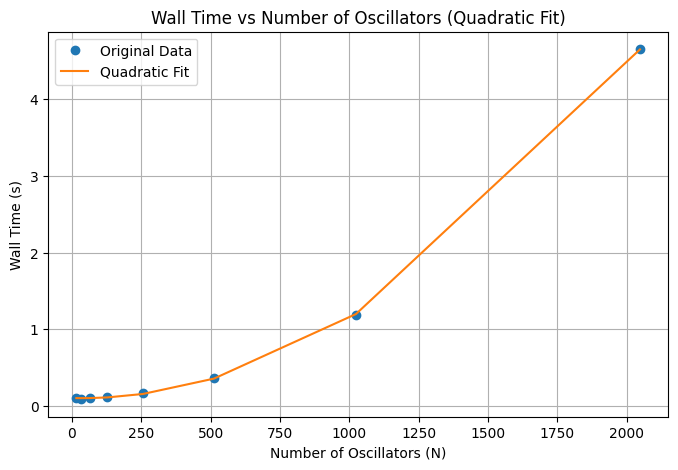

Quadratic Coefficients: [ 1.12476041e-06 -8.10434496e-05  1.00147978e-01]
R-squared: 0.9999536310550938


In [14]:
coeffs = np.polyfit(N_values, wall_times, 2)
quadratic_fit = np.poly1d(coeffs)

predicted_times = quadratic_fit(N_values)

plt.figure(figsize=(8, 5))
plt.plot(N_values, wall_times, 'o', label='Original Data')
plt.plot(N_values, predicted_times, '-', label='Quadratic Fit')
plt.xlabel('Number of Oscillators (N)')
plt.ylabel('Wall Time (s)')
plt.title('Wall Time vs Number of Oscillators (Quadratic Fit)')
plt.legend()
plt.grid()
plt.show()

# Calculate residuals
residuals = wall_times - predicted_times

# Calculate R-squared
ss_res = np.sum(residuals**2) 
ss_tot = np.sum((wall_times - np.mean(wall_times))**2) 
r_squared = 1 - (ss_res / ss_tot)

print("Quadratic Coefficients:", coeffs)
print("R-squared:", r_squared)